In [ ]:
# Install the required libraries in your Google Colab environment
!pip install gymnasium mujoco stable-baselines3 ollama -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import the necessary libraries
import gymnasium as gym
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import ollama
import matplotlib.animation as animation
import re
import json

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from google.colab import data_table
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataframe back from the pickle file
trajectory_df = pd.read_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/02_trajectories/0_initial_training/0_initial_trajectory_reacher_df.pkl')      # Update directory location 1

In [ ]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Check the data type of each column
print(type(trajectory_df['Episode'][0]))
print(type(trajectory_df['Timestep'][0]))
print(type(trajectory_df['State'][0]))
print(type(trajectory_df['Action'][0]))
print(type(trajectory_df['Reward'][0]))
print(type(trajectory_df['Next State'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>


In [ ]:
def apply_pca(trajectory_df):
    """
    Apply PCA to reduce trajectory features to 3 principal components.
    Print variance explained and cumulative variance for the 3 components.
    """
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Extract numerical values from state and action
    state_columns = [f"state_{i}" for i in range(len(trajectory_df["State"].iloc[0]))]
    action_columns = [f"action_{i}" for i in range(len(trajectory_df["Action"].iloc[0]))]

    # Expand state and action columns
    state_values = np.vstack(trajectory_df["State"].values)
    action_values = np.vstack(trajectory_df["Action"].values)

    # Create a new DataFrame with extracted features
    feature_df = pd.DataFrame(state_values, columns=state_columns)
    action_df = pd.DataFrame(action_values, columns=action_columns)

    # Concatenate extracted values with reward
    feature_df = pd.concat([feature_df, action_df, trajectory_df["Reward"].reset_index(drop=True)], axis=1)

    # Handle missing values (if any)
    feature_df.fillna(0, inplace=True)

    # Standardize the data (always important for PCA!)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(feature_df)

    # Apply PCA with 3 components
    pca = PCA(n_components=7)
    pca_features = pca.fit_transform(X_scaled)

    pc_loadings = pd.DataFrame(
    pca.components_[:7],  # First 7 principal components
    columns=feature_df.columns,
    index=[f'PC{i}' for i in range(1, 8)])

    print(pc_loadings)
    print("Explained variance ratio:", pca.explained_variance_ratio_[:7])

    # Create output dataframe with PCs
    trajectory_df_pca = trajectory_df.copy()
    trajectory_df_pca["PC1"] = pca_features[:, 0]
    trajectory_df_pca["PC2"] = pca_features[:, 1]
    trajectory_df_pca["PC3"] = pca_features[:, 2]
    trajectory_df_pca["PC4"] = pca_features[:, 3]
    trajectory_df_pca["PC5"] = pca_features[:, 4]
    trajectory_df_pca["PC6"] = pca_features[:, 5]
    trajectory_df_pca["PC7"] = pca_features[:, 6]

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    # Print variance info
    for i in range(7):
        print(f"PC{i+1} explains {explained_variance[i]*100:.2f}% variance.")

    print(f"Cumulative variance explained by 7 PCs: {cumulative_variance[-1]*100:.2f}%")

    return trajectory_df_pca, pca

In [ ]:
def find_optimal_clusters(data, max_clusters=30):
    """
    Determine the optimal number of clusters using Calinski-Harabasz Index.
    Also prints Silhouette and Davies-Bouldin scores for comparison.
    """
    best_ch_score = -1
    best_k = 2

    print("\nEvaluating clustering metrics:\n")

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Compute metrics
        silhouette_avg = silhouette_score(data, cluster_labels)
        dbi = davies_bouldin_score(data, cluster_labels)
        ch = calinski_harabasz_score(data, cluster_labels)

        print(f"\nFor k = {k}:")
        print(f"   Silhouette Score       = {silhouette_avg:.4f}")
        print(f"   Davies-Bouldin Index   = {dbi:.4f}")
        print(f"   Calinski-Harabasz Index= {ch:.2f}")

        # Compute per-cluster silhouette scores
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        for cluster in range(k):
            cluster_silhouette = sample_silhouette_values[cluster_labels == cluster]
            cluster_mean_silhouette = np.mean(cluster_silhouette)
            print(f"     Cluster {cluster}: mean silhouette = {cluster_mean_silhouette:.4f}")

        # Select best k using highest Calinski-Harabasz Index
        if ch > best_ch_score:
            best_ch_score = ch
            best_k = k

    print(f"\n Optimal number of clusters selected: {best_k} (based on highest Calinski-Harabasz index = {best_ch_score:.2f})")
    return best_k

In [ ]:
def apply_clustering(trajectory_df_pca):
    """
    Apply KMeans clustering to select representative timesteps for LLM evaluation.
    Uses PC1–PC3 by default.
    """
    features = ["PC1", "PC2", "PC3","PC4","PC5","PC6","PC7"]
    X = trajectory_df_pca[features]

    # Find optimal number of clusters using all three metrics
    optimal_clusters = find_optimal_clusters(X)

    # Apply KMeans with best k
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    trajectory_df_pca["Cluster"] = kmeans.fit_predict(X)

    # Select one representative per cluster
    cluster_representatives = trajectory_df_pca.groupby("Cluster").first().reset_index()

    return trajectory_df_pca, cluster_representatives, kmeans

In [ ]:
import seaborn as sns

def visualize_7_pca_components(trajectory_df_pca):
    """
    Visualize the first 7 principal components using pairwise scatterplots, colored by cluster.
    """
    # Select the first 7 PCs and the cluster column
    pc_columns = [f"PC{i}" for i in range(1, 8)]
    plot_df = trajectory_df_pca[pc_columns + ["Cluster"]].copy()
    plot_df["Cluster"] = plot_df["Cluster"].astype(str)  # For coloring

    # Create pairplot
    sns.pairplot(
        plot_df,
        vars=pc_columns,
        hue="Cluster",
        palette="viridis",
        diag_kind="kde",
        corner=True  # To avoid redundant upper triangle
    )
    plt.suptitle("Pairwise Scatter Plots of First 7 Principal Components", y=1.02)
    plt.show()

In [ ]:
trajectory_df_pca, pca = apply_pca(trajectory_df)
print(pca)

      state_0   state_1   state_2   state_3   state_4   state_5   state_6  \
PC1 -0.020932 -0.176546  0.443081  0.452670 -0.220926  0.387085  0.264763   
PC2  0.377509  0.427914 -0.182779 -0.091364 -0.041791 -0.110014  0.117698   
PC3  0.433787  0.294886  0.035923  0.179643  0.585638 -0.008733 -0.017118   
PC4  0.207490  0.035470  0.047475  0.001496  0.346717  0.351934  0.273177   
PC5 -0.251380 -0.028198 -0.279645 -0.221491 -0.004273 -0.337062  0.529345   
PC6  0.029115  0.102659 -0.013092 -0.218320 -0.055508  0.215048  0.568286   
PC7  0.095785 -0.168945  0.130975 -0.031162  0.060629  0.021880 -0.206675   

      state_7   state_8   state_9  action_0  action_1    Reward  
PC1  0.422443  0.091897  0.234728 -0.087592  0.141246 -0.169695  
PC2  0.058599  0.497728  0.109941  0.137861  0.287857 -0.489690  
PC3  0.165192 -0.229605  0.324271 -0.324321 -0.186252  0.151447  
PC4  0.011515 -0.226724 -0.462744  0.492444  0.331065  0.130246  
PC5  0.324619 -0.204467  0.274999 -0.066200  0.371443

In [ ]:
trajectory_df_pca, cluster_representatives, kmeans = apply_clustering(trajectory_df_pca)


Evaluating clustering metrics:


For k = 2:
   Silhouette Score       = 0.2871
   Davies-Bouldin Index   = 1.5102
   Calinski-Harabasz Index= 1875.75
     Cluster 0: mean silhouette = 0.2440
     Cluster 1: mean silhouette = 0.3417

For k = 3:
   Silhouette Score       = 0.3286
   Davies-Bouldin Index   = 1.2300
   Calinski-Harabasz Index= 1972.50
     Cluster 0: mean silhouette = 0.3898
     Cluster 1: mean silhouette = 0.3207
     Cluster 2: mean silhouette = 0.2103

For k = 4:
   Silhouette Score       = 0.2928
   Davies-Bouldin Index   = 1.3676
   Calinski-Harabasz Index= 1746.89
     Cluster 0: mean silhouette = 0.3641
     Cluster 1: mean silhouette = 0.2214
     Cluster 2: mean silhouette = 0.3516
     Cluster 3: mean silhouette = 0.1627

For k = 5:
   Silhouette Score       = 0.3118
   Davies-Bouldin Index   = 1.2728
   Calinski-Harabasz Index= 1697.18
     Cluster 0: mean silhouette = 0.3540
     Cluster 1: mean silhouette = 0.3413
     Cluster 2: mean silhouette = 0.2184
   

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(cluster_representatives)
print(kmeans)

   Cluster  Episode  Timestep  \
0        0        1        12   
1        1        1         0   
2        2        1         3   

                                               State  \
0  [0.9758758274324504, 0.9655217868993612, 0.218...   
1  [0.9966714523745062, 0.9994154655366121, -0.08...   
2  [0.998975581526324, 0.9996838012198239, -0.045...   

                        Action    Reward  \
0  [0.008616187, -0.025232412] -0.057002   
1    [0.10572705, 0.013632492] -0.106170   
2     [0.059552886, 0.1951674] -0.126663   

                                          Next State       PC1       PC2  \
0  [0.9681985298796676, 0.9472774036292214, 0.250...  0.367690  0.288787   
1  [0.9970110853031734, 0.9994319231147754, -0.07... -1.129376  0.762017   
2  [0.9998527515119078, 0.9999334402378199, -0.01... -0.381678  1.548017   

        PC3       PC4       PC5       PC6       PC7  
0  2.101704  1.212582  0.214837  0.559742 -0.807489  
1  0.823859  2.237380 -0.980504 -0.010317 -0.462330 

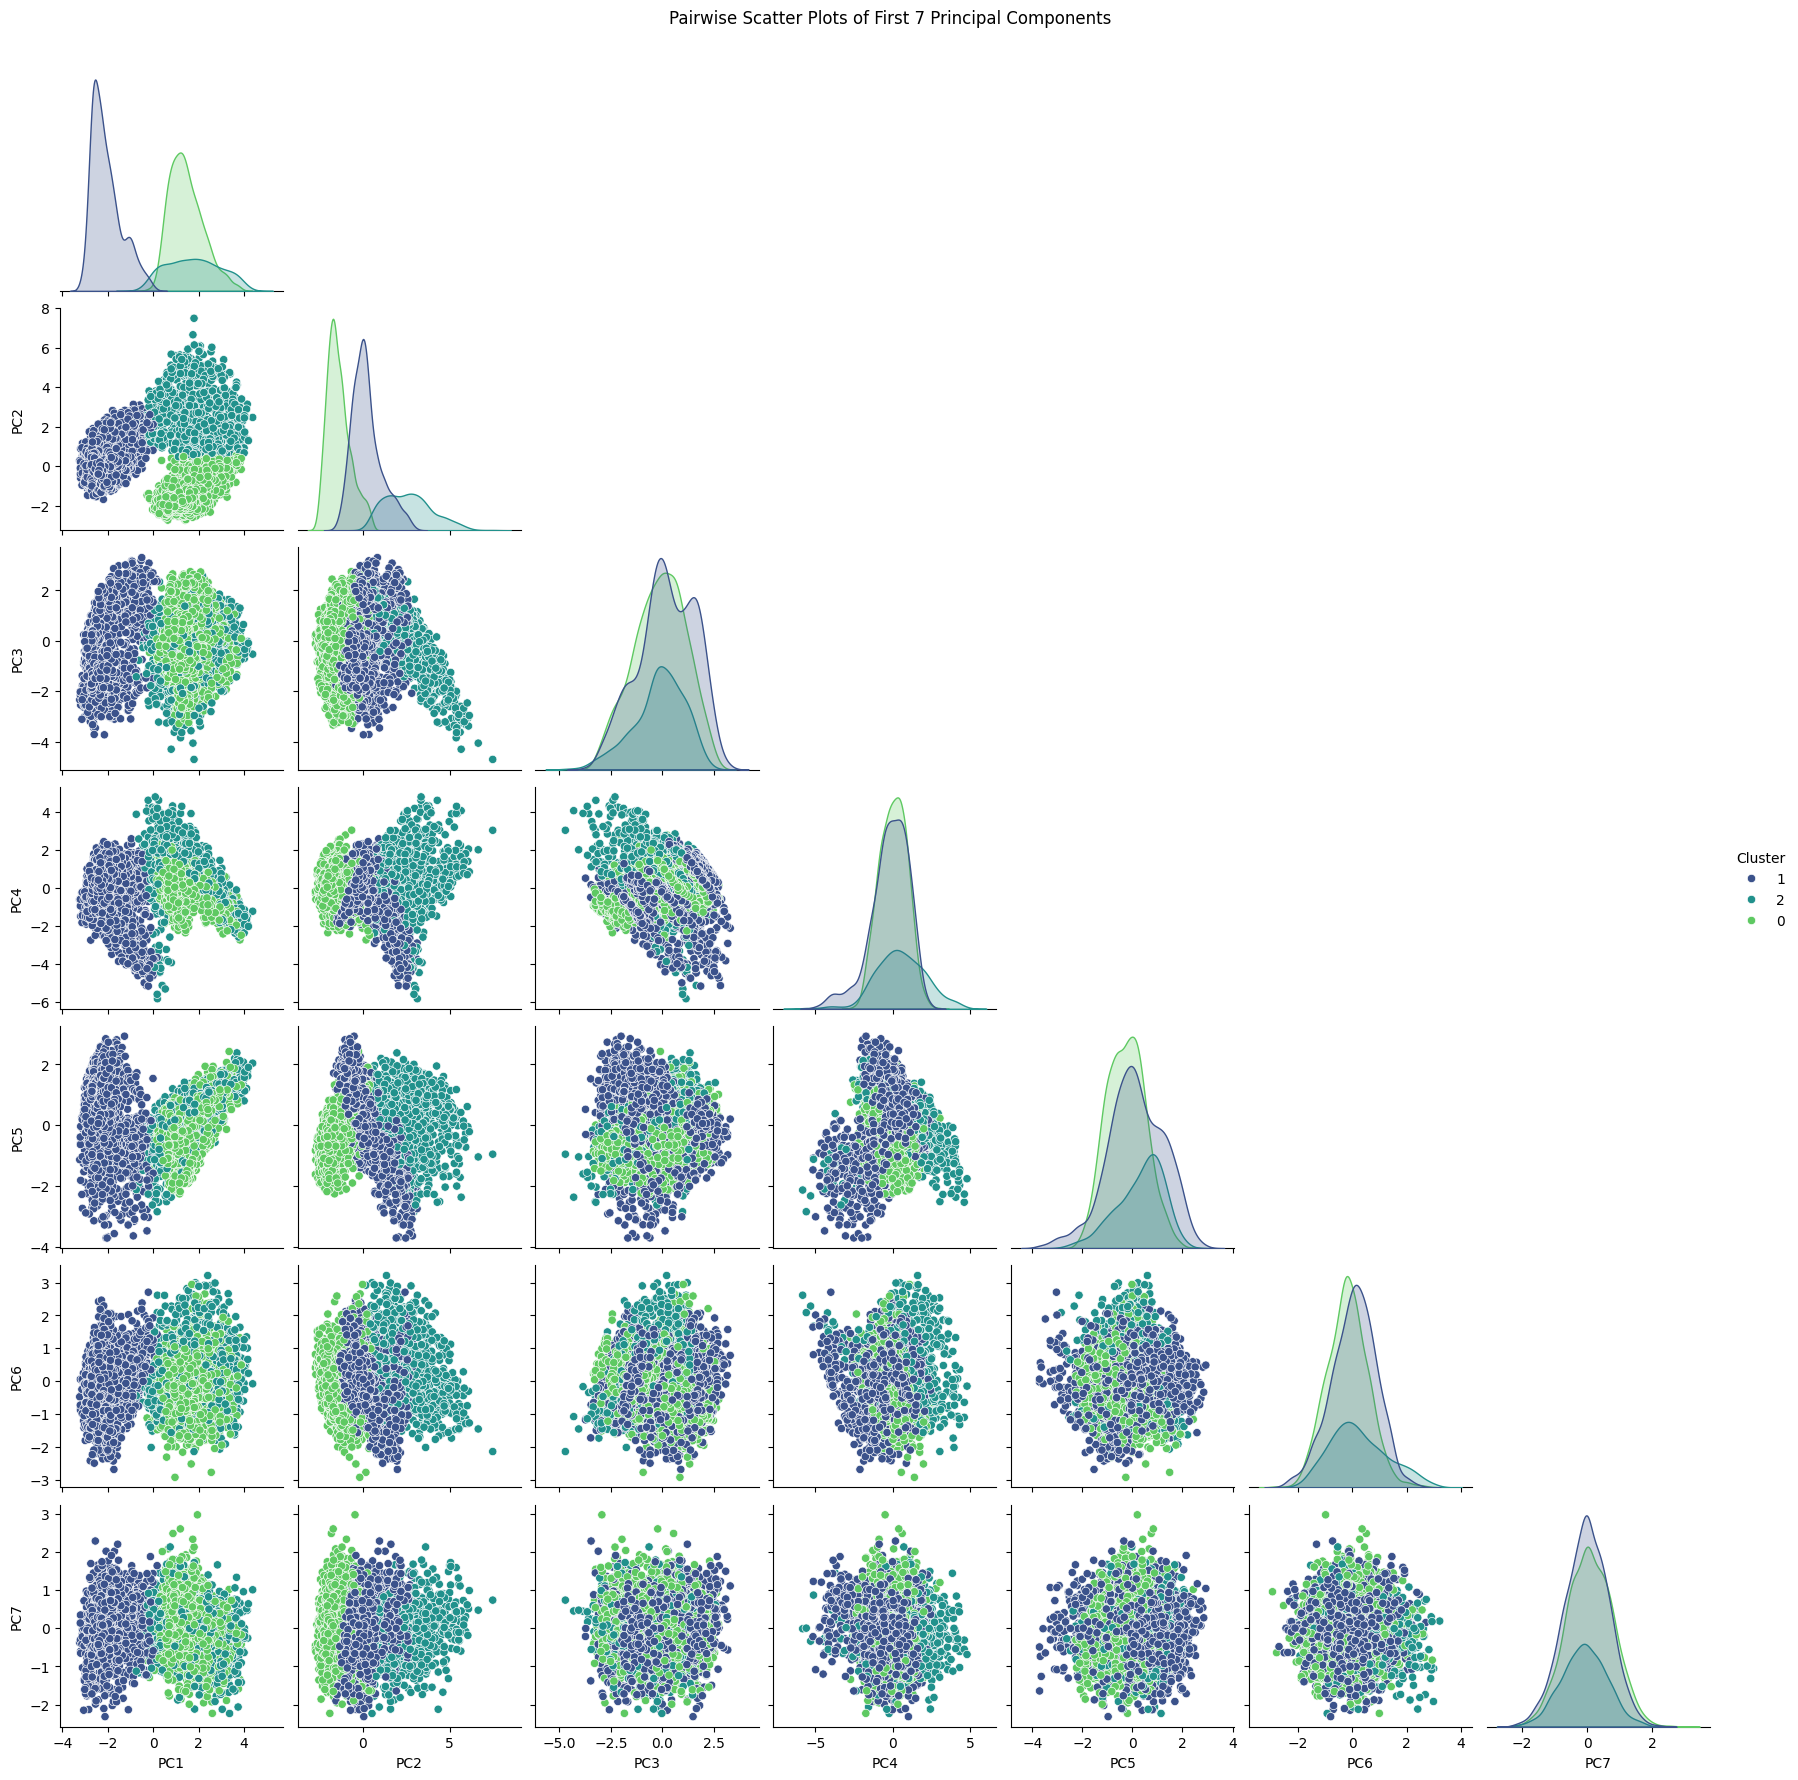

In [ ]:
visualize_7_pca_components(trajectory_df_pca)

B: LLM FEEDBACK IMPLEMENTATION <br>
SECTION B.0: LOADING THE LLM
*   Step B.0.1: Install Required Libraries
*   Step B.0.2: Setting the environment varaible  
*   Step B.0.3: Setup and Load the Pretrained LLM

In [ ]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 8.6 MB/s eta 0:00:00


In [ ]:
%load_ext colabxterm

In [ ]:
%xterm
# Execute the following commands sequentially in Xterm
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull mistral
# ollama list
# ollama show mistral llama3.2

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
def visualize_feedback_progress(progress):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Progress (%)")
    ax.set_ylabel("Completion")

    def update(frame):
        ax.clear()
        ax.barh(["LLM Feedback"], [frame], color='blue')
        ax.set_xlim(0, 100)
        ax.set_title("Live LLM Feedback Collection Progress")

    ani = animation.FuncAnimation(fig, update, frames=progress, repeat=False)
    plt.show()

In [ ]:
def get_llm_feedback(State, Action, Reward, Next_State, Episode, Timestep, PC1, PC2, PC3, PC4, PC5, PC6, PC7):
    """
    Query Mistral LLM for feedback on action effectiveness and reward appropriateness, incorporating principal components.
    The response is expected to be a JSON object with keys: justification, llm_score_1, llm_score_2.
    """
    prompt = f"""
    You are an expert in analyzing reinforcement learning trajectories in a robotic control environment (Reacher-v5).
            You will process a structured dataset containing agent trajectories and analyze each row by assessing whether:
            - the action taken is effective or not, and
            - whether the reward awarded is appropriate or not.

    You are provided with a trajectory dataset containing:
      - Episode: {Episode}
      - Time Step: {Timestep}
      - State: {State}
      - Action taken by agent: {Action}
      - Reward: {Reward}
      - Next state: {Next_State}
      - Principal Components:
        - PC1= {PC1}: PC1: Main variation in joint angles, velocities, and fingertip position linked to overall reach success.
        - PC2= {PC2}: Combination of joint angles and fingertip positions associated with strong actions and lower rewards.
        - PC3= {PC3}: Contrast between specific joint configurations and action strengths during movement adjustments.
        - PC4= {PC4}: Large corrective actions applied when the fingertip is far from the target.
        - PC5= {PC5}: Balancing fingertip position and action magnitude for reach accuracy.
        - PC6= {PC6}: Fine-tuning joint velocity and fingertip position against strong actions.
        - PC7= {PC7}: Alternating torque commands to joints for subtle target corrections.

    Based on this data, evaluate and return feedback as a JSON object with the following format:

            {{
               "justification": "<brief explanation of your decision>",
               "llm_score_1": <integer>,   // +2 for effective, 0 for neutral, -2 for ineffective
               "llm_score_2": <integer>    // +1 if reward is appropriate, -1 if inappropriate
             }}

             Only return a valid JSON object with no surrounding commentary or explanation.
            """

    answer = ollama.generate(model="mistral", prompt=prompt, options={"temperature": 0.6, "seed": 4})
    response_text = answer['response'].strip()

    try:
        feedback = json.loads(response_text)
    except json.JSONDecodeError:
        print(f"Warning: Could not parse LLM response as JSON: {response_text}")
        feedback = None

    return feedback

In [ ]:
def collect_llm_feedback_cluster(cluster_representatives):
    """
    Collect LLM feedback for each cluster representative assuming JSON-style response.
    Returns:
        - llm_feedback_data (dict): Cluster ID → full feedback (dict)
        - feedback_df (DataFrame): Contains Cluster ID, justification, llm_score_1, llm_score_2
    """
    llm_feedback_data = {}
    feedback_records = []

    for i, (_, row) in tqdm(enumerate(cluster_representatives.iterrows()), total=len(cluster_representatives)):
        # Get LLM response (expected to return a JSON/dict-like structure)
        feedback = get_llm_feedback(
            row["State"], row["Action"], row["Reward"], row["Next State"],
            row["Episode"], row["Timestep"], row["PC1"], row["PC2"], row["PC3"],
            row["PC4"], row["PC5"], row["PC6"], row["PC7"])

        cluster_id = row["Cluster"]
        llm_feedback_data[cluster_id] = feedback

        # Check if feedback is None before accessing it
        if feedback is None:
            print(f"LLM feedback for Cluster {cluster_id} was None. Skipping record creation for this cluster.")
            continue  # Skip to the next iteration if feedback is None

        # Extract values from feedback dictionary
        justification = feedback.get("justification", "N/A")
        score_1 = feedback.get("llm_score_1", 0)
        score_2 = feedback.get("llm_score_2", 0)


        print(f"\n--- Cluster {cluster_id} ---")
        print(f"Justification: {justification}")
        print(f"llm_score_1: {score_1}, llm_score_2: {score_2}")

        feedback_records.append({
            "Cluster": cluster_id,
            "Justification": justification,
            "LLM_Score_1": score_1,
            "LLM_Score_2": score_2,
            "LLM_Score_Total": score_1 + score_2
        })

    # Convert records into a DataFrame
    feedback_df = pd.DataFrame(feedback_records)
    return llm_feedback_data, feedback_df

In [ ]:
llm_feedback_data, llm_feedback_df = collect_llm_feedback_cluster(cluster_representatives)

 33%|███▎      | 1/3 [00:08<00:17,  8.96s/it]


--- Cluster 0 ---
Justification: The action taken by the agent did not result in an effective reach as it led to a decrease in the fingertip position towards the target, indicated by a negative reward. The principal component analysis suggests that this action was associated with a strong action and lower rewards (PC2), and large corrective actions applied when the fingertip is far from the target (PC4).
llm_score_1: -2, llm_score_2: -1


 67%|██████▋   | 2/3 [00:12<00:05,  5.90s/it]


--- Cluster 1 ---
Justification: The action taken by the agent results in a decrease in reward (-0.106), which suggests an ineffective movement. The principal component PC1, associated with reach success, has a negative value, indicating that the joint angles and velocities were not conducive to reaching the target. Additionally, PC2, related to strong actions and lower rewards, also has a positive value. Therefore, the LLM scores are as follows.
llm_score_1: -2, llm_score_2: -1


100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


--- Cluster 2 ---
Justification: The action taken by the agent moves the fingertip closer to the target (positive movement along PC1), but it results in a lower reward, indicating that the reach might not have been completely successful. The principal component PC2 suggests strong actions associated with lower rewards, which aligns with this observation.
llm_score_1: 0, llm_score_2: -1


In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_feedback_df)

,Cluster,Justification,LLM_Score_1,LLM_Score_2,LLM_Score_Total
0,0,The action taken by the agent did not result i...,-2,-1,-3
1,1,The action taken by the agent results in a dec...,-2,-1,-3
2,2,The action taken by the agent moves the finger...,0,-1,-1


In [ ]:
llm_feedback_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/02_trajectories/2_llm_feedback/0_llm_d_justification.pkl')     #Update Directory Location 2

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def interpolate_llm_scores(trajectory_df_pca, llm_feedback_df):
    """
    Assigns LLM feedback scores (from llm_feedback_df) to each trajectory row using cluster mapping,
    and interpolates missing scores.
    """
    # Create mapping: Cluster ID → LLM_Score_Total
    cluster_to_score = dict(zip(llm_feedback_df["Cluster"], llm_feedback_df["LLM_Score_Total"]))

    # Map score to each row in trajectory_df_pca
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["Cluster"].map(cluster_to_score)

    # Interpolate missing values if any (e.g., if some clusters were missed)
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["LLM_Feedback_Score"].interpolate()

    return trajectory_df_pca

In [ ]:
llm_score_df = interpolate_llm_scores(trajectory_df_pca, llm_feedback_df)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_score_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Group the data by 'episode'
episode_data = trajectory_df_pca.groupby('Episode')
# Loop through each episode
for episode, data in episode_data:

    cluster_list = data['Cluster'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['Timestep'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {cluster_list}")

Episode 1:Total timesteps 50: [1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 2:Total timesteps 50: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 3:Total timesteps 50: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 4:Total timesteps 50: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Episode 5:Total timesteps 50: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 6:Total timesteps 50: [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0

In [ ]:
# Group the data by 'episode'
episode_data = llm_score_df.groupby('Episode')
# Loop through each episode
for episode, data in episode_data:
    # Extract lane indices
    llm_score_list = data['LLM_Feedback_Score'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['Timestep'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {llm_score_list}")

Episode 1:Total timesteps 50: [-3, -3, -3, -1, -3, -3, -3, -3, -1, -1, -1, -1, -3, -1, -3, -3, -3, -1, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3]
Episode 2:Total timesteps 50: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3]
Episode 3:Total timesteps 50: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3]
Episode 4:Total timesteps 50: [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3]
Episode 5:Total timesteps 50: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

Section B.2: REWARD MODELLING(LLM FEEDBACK)

*   Step B.2.1: Recalibrate Reward Based on LLM Feedback
*   Step 3.2.2: Displaying the recalibrated rewards based on LLM feedback
*   Step 3.2.3: Access the reward for a specific step

In [ ]:
# Step B.2.3: Recalibrate Reward Based on LLM Feedback
# Function to recalibrate the rewards
def recalibrate_rewards(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Create the 'Recalibrated_rewards' column
    df_copy['Recalibrated_rewards'] = df_copy['Reward'] + df_copy['LLM_Feedback_Score']

    # Get the list of recalibrated rewards
    recalibrated_rewards_list = df_copy['Recalibrated_rewards'].tolist()

    return df_copy, recalibrated_rewards_list

In [ ]:
# Apply the function to recalibrate rewards
recalibrated_df, recalibrated_rewards_list = recalibrate_rewards(llm_score_df)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(recalibrated_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
recalibrated_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/02_trajectories/2_llm_feedback/1_llm_feedback_reacher_df_1.pkl')         # Update directory location 3

In [ ]:
# To access the reward for a specific step:
for i, feedback in enumerate(recalibrated_rewards_list):
    human_recalibrated_reward_for_step = recalibrated_rewards_list[i]
    print(f"Recalibrated reward for step {i}: {human_recalibrated_reward_for_step}")

Recalibrated reward for step 0: -3.106169669545615
Recalibrated reward for step 1: -3.102442682387911
Recalibrated reward for step 2: -3.1109565746019774
Recalibrated reward for step 3: -1.126663182310133
Recalibrated reward for step 4: -3.086046005954756
Recalibrated reward for step 5: -3.0816385759284923
Recalibrated reward for step 6: -3.0711241449686777
Recalibrated reward for step 7: -3.0748510765152086
Recalibrated reward for step 8: -1.0845070608596967
Recalibrated reward for step 9: -1.0772711577679144
Recalibrated reward for step 10: -1.078535759770203
Recalibrated reward for step 11: -1.0699281414183828
Recalibrated reward for step 12: -3.0570018484485186
Recalibrated reward for step 13: -1.0786985595355392
Recalibrated reward for step 14: -3.0688124285460976
Recalibrated reward for step 15: -3.0776261678273173
Recalibrated reward for step 16: -3.0762381389680167
Recalibrated reward for step 17: -1.113290984634172
Recalibrated reward for step 18: -3.090364935184487
Recalibrat

SECTION A.5: MODEL TRAINING(HUMAN FEEDBACK DIRECT- IDEAL CASE SCENARIO)
*   Step A.5.1: CUSTOM REWARD FUNCTION
*   Step A.5.2: LOAD THE SAVED INITIALLY TRAINED PPO MODEL FROM GOOGLE DRIVE
*   Step A.5.3: TRAIN/UPDATE PPO MODEL WITH RECALIBRATED REWARD
*   Step A.5.4: SAVE THE TRAINED MODEL(HF_IDEAL) FOR TESTING

In [ ]:
# Step A.5.1: CUSTOM REWARD FUNCTION
def custom_reward(self, env, state, action, next_state, reward, done):
    # Access and recalculate the reward using human_feedback_data or recalibrate_rewards_human function
    global step_counter
    try:
        step_counter
    except NameError:
        step_counter = 0

    reward = recalibrated_rewards_list[step_counter]
    step_counter += 1
    return reward

# Create a new environment class that wraps your original environment and overrides the default reward function with your custom function
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        reward = custom_reward(self, self.env, self.last_obs, action, next_state, reward, done)
        # custom_reward should be defined and accessible to your class
        self.last_obs = next_state
        return next_state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        global step_counter
        step_counter = 0
        self.last_obs = self.env.reset(**kwargs)[0]  # Assuming Gymnasium env returns (obs, info)
        return self.last_obs, {}  # Assuming Gymnasium env requires (obs, info)
# Create and wrap the environment with your custom reward wrapper
# env_human = CustomRewardWrapper(gym.make('highway-v0'))

PPO training and Training logs

In [ ]:
drive_log_dir = "/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/00_training_logs/4_log_dir/4_ppo_reacher_llmf_1"          # Update directory location 4

In [ ]:
# Train PPO with Custom Rewards
def train_ppo_with_custom_rewards(log_dir=drive_log_dir, total_timesteps=200000):
    os.makedirs(log_dir, exist_ok=True)
    env = CustomRewardWrapper(gym.make("Reacher-v5"))
    env = Monitor(env, log_dir)
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
    model.learn(total_timesteps=total_timesteps)
    model.save('/content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/01_trained_models/4_ppo_reacher_llmf_1')   # Update directory location 5
    return model, log_dir

In [ ]:
# Execute Training and Convergence Tracking
model, log_dir = train_ppo_with_custom_rewards(total_timesteps=200000)

Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/05_zero_shot_llm_3/03_reacher_data/00_training_logs/4_log_dir/4_ppo_reacher_llmf_1/PPO_3


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -142     |
| time/              |          |
|    fps             | 621      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | -142         |
| time/                   |              |
|    fps                  | 481          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0052304007 |
|    clip_fraction        | 0.0552       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.00616     |
|    learning_r

In [ ]:
log_path = os.path.join(drive_log_dir, "monitor.csv")
df = pd.read_csv(log_path, skiprows=1)
## Ensure episodes are logged correctly
df.reset_index(inplace=True)
df.rename(columns={"index": "episode", "r": "reward", "l": "length", "t": "time_step"}, inplace=True)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(df.head())

,episode,reward,length,time_step
0,0,-142.461548,50,7.185574
1,1,-142.461548,50,7.249135
2,2,-142.461548,50,7.313644
3,3,-142.461548,50,7.377109
4,4,-142.461548,50,7.441596
